
# Four Panel Map

By reading near-surface data from the NASA MERRA2 reanalysis product from May 31, 2021, we can create a four panel plot showing:

* the pressure of the bottom model level (near the surface)
* the modeled sea level pressure
* the calculated sea level pressure (constant $\overline{T}$)
* the calculated sea level pressure (constant $\overline\Gamma=6.5$ K km$^{-1}$)

As before, this first batch of code contains the import statements, a worker function, but it reads in some data, too. So you will need to have `MERRA2.tavg3.20210531.bottom_level_for_week_6.nc4` and in the same directory with this notebook file for this to work.

## Remember to download this to save your work!


In [1]:
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
from metpy.plots import add_metpy_logo
from metpy.units import units

crs = ccrs.Robinson()

# Function used to create the map subplots
def plot_background(ax):
    #ax.set_extent([235., 290., 20., 55.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    return ax

# Open the example netCDF data
ds = xr.open_dataset('MERRA2.tavg3.20210531.bottom_level_for_week_6.nc4')

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(ds['lon'], ds['lat'])

# Pull out the 0000–0300Z average and 1200–1500Z average data
ml_z_0130 = ds['H'][0][0]*units.meters # middle-of-layer height in meters
ml_p_0130 = ds['PL'][0][0]*units.pascals # middle-of-layer pressure in pascals
slp_0130 = ds['SLP'][0]*units.pascals # sea level pressure from model output
ml_t_0130 = ds['T'][0][0]*units.kelvins # middle-of-layer temperature in Kelvins
ml_z_1330 = ds['H'][1][0]*units.meters # middle-of-layer height in meters
ml_p_1330 = ds['PL'][1][0]*units.pascals # middle-of-layer pressure in pascals
slp_1330 = ds['SLP'][1]*units.pascals # sea level pressure from model output
ml_t_1330 = ds['T'][1][0]*units.kelvins # middle-of-layer temperature in Kelvins

# calculate a daily average from 12-hours-apart values
ml_z_avg = ((ml_z_0130 + ml_z_1330.data) / 2.)
ml_p_avg = ((ml_p_0130 + ml_p_1330.data) / 2.)
slp_avg = ((slp_0130 + slp_1330.data) / 2.)
ml_t_avg = ((ml_t_0130 + ml_t_1330.data) / 2.)

# calculate the SLP based on the mid-layer temperature
_Hint:_ verify that the argument of the exponential is unitless, remembering that a joule is a kg m$^2$ s$^{-2}$

In [2]:
'''
# some helper variables to make your calculation a bit easier
gravity = 9.80665*units.meters/units.seconds/units.seconds
Rd = 287.047*units.joules/units.kg/units.kelvin

slp_const_temp_avg =
'''

'\n# some helper variables to make your calculation a bit easier\ngravity = 9.80665*units.meters/units.seconds/units.seconds\nRd = 287.047*units.joules/units.kg/units.kelvin\n\nslp_const_temp_avg =\n'

# calculate the SLP based on a 6.5 K/km lapse rate between the mid-layer height and zero meters
_Hint:_ verify that the exponent is unitless, remembering that a joule is a kg m$^2$ s$^{-2}$. Also, I at first made a mistake when I plugged in the `ml_z_avg`, because I treated it like $z$ instead of $z_0$, which effectively turned my mountains into valleys and vice versa. (Note that there is no $z_0$ in the equation you should use. But the correct value of $z$ can be easily calculated from `ml_z_avg` if you think carefully about limits of integration.)

In [3]:
'''
# another helper variable to make your calculation a bit easier
gamma = 0.0065*units.kelvin/units.meter

slp_const_gamma_avg = 
'''

'\n# another helper variable to make your calculation a bit easier\ngamma = 0.0065*units.kelvin/units.meter\n\nslp_const_gamma_avg = \n'

## Plot some data!

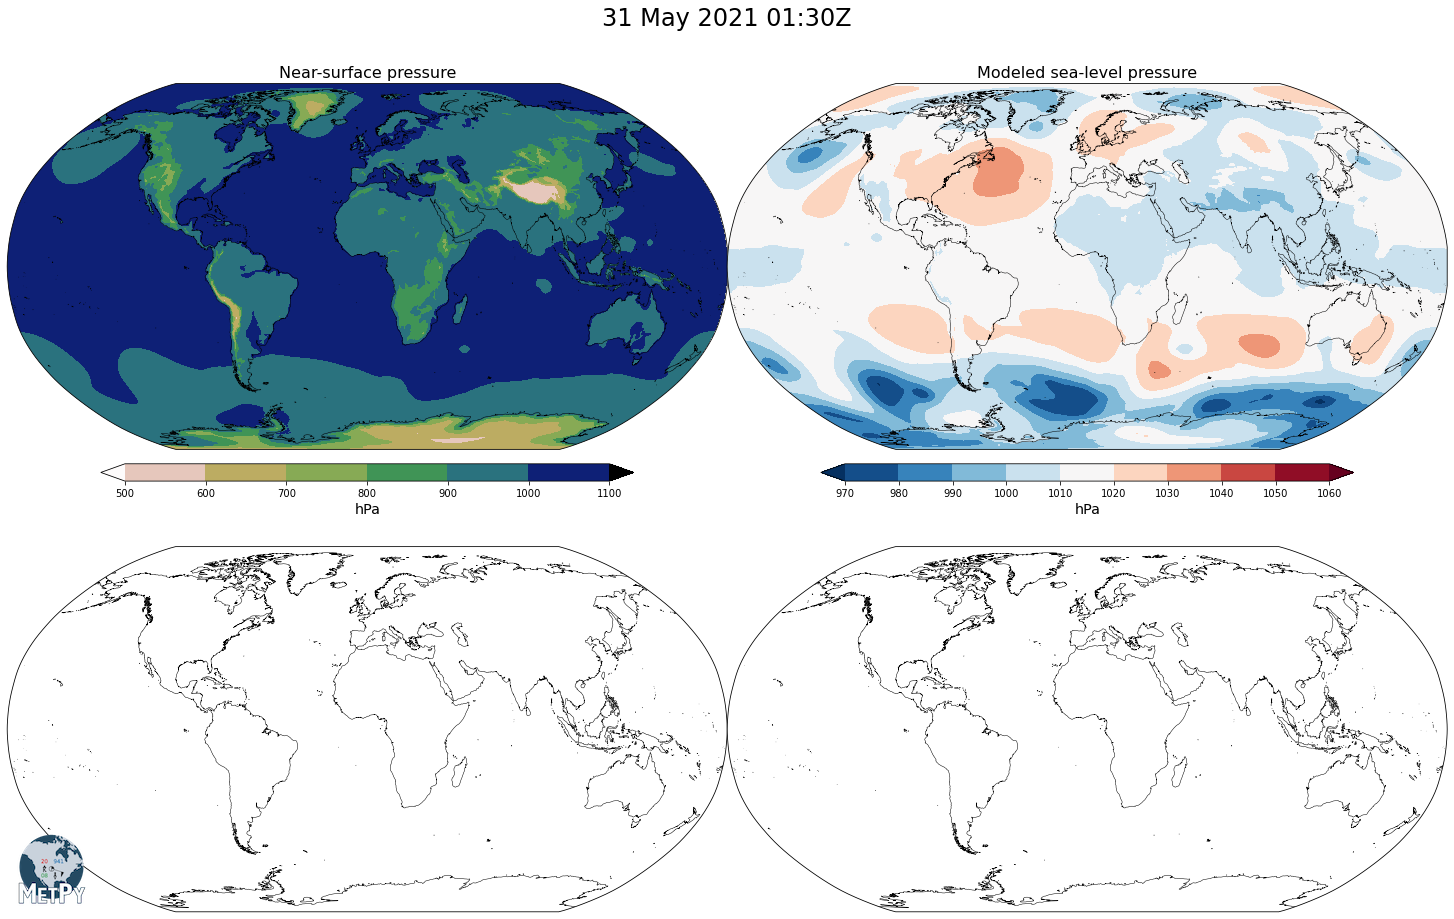

In [4]:
# Do unit conversions to what we wish to plot
ml_p_avg = ml_p_avg.metpy.convert_units('hPa')
slp_avg = slp_avg.metpy.convert_units('hPa')
'''
slp_const_temp_avg = slp_const_temp_avg.metpy.convert_units('hPa')
slp_const_gamma_avg = slp_const_gamma_avg.metpy.convert_units('hPa')
'''

# Create the figure and plot background on different axes
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(20, 13), constrained_layout=True,
                          subplot_kw={'projection': crs})
add_metpy_logo(fig, 14, 12, size='small')
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)

ps_levs = [500, 600, 700, 800, 900, 1000, 1100]
slp_levs = [970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060]
# Upper left plot - near-surface pressure
cf1 = axlist[0].contourf(lon_2d, lat_2d, ml_p_avg, cmap='gist_earth_r', transform=ccrs.PlateCarree(), levels=ps_levs, extend='both')
axlist[0].set_title('Near-surface pressure', fontsize=16) 
cb1 = fig.colorbar(cf1, ax=axlist[0], orientation='horizontal', shrink=0.74, pad=0)
cb1.set_label('hPa', size='x-large')

# Upper right plot - modeled sea level pressure
cf2 = axlist[1].contourf(lon_2d, lat_2d, slp_avg, cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=slp_levs, extend='both')
axlist[1].set_title('Modeled sea-level pressure', fontsize=16)
cb2 = fig.colorbar(cf2, ax=axlist[1], orientation='horizontal', shrink=0.74, pad=0)
cb2.set_label('hPa', size='x-large')
'''
# Lower left plot - calculated sea level pressure, constant temperature
cf3 = axlist[2].contourf(lon_2d, lat_2d, slp_const_temp_avg, cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=slp_levs, extend='both')
axlist[2].set_title(r'Calculated sea-level pressure, $\overline{T}$', fontsize=16) 
cb3 = fig.colorbar(cf3, ax=axlist[2], orientation='horizontal', shrink=0.74, pad=0)
cb3.set_label('hPa', size='x-large')

# Lower right plot - calculated sea level pressure, constant lapse rate
cf4 = axlist[3].contourf(lon_2d, lat_2d, slp_const_gamma_avg, cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=slp_levs, extend='both')
axlist[3].set_title(r'Calculated sea-level pressure, $\overline{\Gamma}$', fontsize=16)
cb4 = fig.colorbar(cf4, ax=axlist[3], orientation='horizontal', shrink=0.74, pad=0)
cb4.set_label('hPa', size='x-large')
'''
# Set height padding for plots
fig.set_constrained_layout_pads(w_pad=0., h_pad=0.1, hspace=0., wspace=0.)

# Set figure title
fig.suptitle(ds['time'][0].dt.strftime('%d %B %Y %H:%MZ').values, fontsize=24)

# Display the plot
plt.show()

## EVERYONE: Download this and turn it in!

## GRAD STUDENTS: do this for 0130 and 1330 values, too
The calculations done above were for a daily mean, for reasons discussed by Petty. Once you have your calculations above working (and you've tested them with the plots below so that you're sure they look good), repeate the steps above for the 0130Z and 1330Z data, subtract the 0130Z data from the 1330Z data, and plot the difference. Describe your observations in a cell. (Note that you can change the cells from "code" to "Markdown" using the dropdown at the top.)

_Hint:_ 0130 is not nighttime everywhere, and 1330 is not daytime everywhere. Also, we converted our output to hPa after our calculations before plotting. Watch your units as you work.